In [1]:
# Written by Anna C Helfeld C
# Fall 2018-Winter 2019

# This code uses my solutions written in Octave/Matlab as a guide
# Machine Learning (Andrew Ng class on Coursera)
# Homework 4: Neural Networks 

In [2]:
# Import libraries
from pandas import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import optimize
import math as mth

In [3]:
# "From scratch" neural network - not using MLPClassifier; see HW3 for that implementation
# X contains pixel data of handwritten digits
# y contains digit class (1, 2, 3, etc.)

# Make sure file exists
import os  
os.path.isfile('./ex4data1.mat')    # True  

True

In [4]:
# Load data
import h5py 
digitfile = sio.loadmat('ex4data1.mat') 
digitfile

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [5]:
# Put X and y data into arrays
Xdata = digitfile['X']
ydata = digitfile['y']
Alldata = np.concatenate((Xdata,ydata), axis=1)

In [6]:
Alldatadf = DataFrame(data=Alldata)  #Put data into data frame
Alldatadf.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


In [7]:
Alldatadf_ran = Alldatadf.sample(frac=1) #randomize data
Alldatadf_ran.head() #check 

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
4032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.0
2884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
3135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,6.0
3379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001059,-0.000993,-0.000343,0.000032,0.0,0.0,0.0,0.0,0.0,6.0
2062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4.0


In [8]:
# Split into training data and cross-validation data
Xtrain = Alldatadf_ran.iloc[0:mth.floor(Alldatadf_ran.shape[0]*0.8),0:-1]
ytrain = Alldatadf_ran.iloc[0:mth.floor(Alldatadf_ran.shape[0]*0.8),-1]

Xcv = Alldatadf_ran.iloc[mth.floor(Alldatadf_ran.shape[0]*0.8):Alldatadf_ran.shape[0],0:-1]
ycv = Alldatadf_ran.iloc[mth.floor(Alldatadf_ran.shape[0]*0.8):Alldatadf_ran.shape[0],-1]

In [9]:
# Put into arrays
Xtrain_a = Xtrain.values
ytrain_a = ytrain.values
Xcv_a = Xcv.values
ycv_a = ycv.values

In [10]:
# Define sigmoid and sigmoid gradient functions
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoidgrad(x):
    return sigmoid(x)*(1-sigmoid(x));

In [11]:
# Add bias term to Xtrain_a
Xtrain_ab = np.concatenate((np.ones((Xtrain_a.shape[0],1)),Xtrain_a),axis=1)

In [12]:
# Define parameters of neural network
hl_size = 25 #size of hidden layer
ol_size = 10 #size of output layer
eps = 0.12 #range of random number initialization of theta 
numsam = ytrain_a.size #number of training examples
lam_reg = 1 #regularization

In [13]:
# Initialize theta - the weights in the neural network
Theta1 = np.random.uniform(low=-eps, high=eps, size=(hl_size,Xtrain_a.shape[1]+1)) #25by401
Theta2 = np.random.uniform(low=-eps, high=eps, size=(ol_size,hl_size+1)) #10by26

In [14]:
# Flatten Thetas and put into one 1D array
thetas_oned = np.concatenate((Theta1.flatten(),Theta2.flatten()))

In [15]:
# Check the re-shape of theta1
Theta1_test = thetas_oned[0:hl_size*(Xtrain_a.shape[1]+1)].reshape((hl_size,Xtrain_a.shape[1]+1)) 
Theta1_test.shape

(25, 401)

In [16]:
# Check the re-shape of theta2
Theta2_test = thetas_oned[hl_size*(Xtrain_a.shape[1]+1):].reshape((ol_size,hl_size+1)) 
Theta2_test.shape

(10, 26)

In [17]:
ytrain_a #check

array([8., 5., 6., ..., 8., 6., 9.])

In [18]:
# Function for changing the form of y
#Change to a num_samples by 10 matrix
def reparam_y(y, ol_sz, m):
    yn = np.zeros((y.size,ol_sz))
    for i in range(0,m): # m = num_samples -> 4000
        if y[i]==10:
            yn[i,0]=1
        else:
            yn[i,int(y[i])]=1
    return yn

In [19]:
ycheckn=reparam_y(ytrain_a,ol_size,numsam)
ycheckn #check to make sure it looks right

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
# Forward propogation cost function
# theta1 and theta2 are the weights for the network, hl and ol are hidden and output layer size
# m is number of samples, lam is the regularization parameter
args = (Xtrain_ab, ytrain_a, hl_size, ol_size, numsam, lam_reg)  # parameter values
def fpnn_cost(x, *args):
    thetas = x
    X, y, hl_sz, ol_sz, m, lam = args
    
    #Reshape thetas
    theta1 = thetas[0:hl_sz*(X.shape[1])].reshape((hl_sz,X.shape[1]))
    theta2 = thetas[hl_sz*(X.shape[1]):].reshape((ol_sz,hl_sz+1)) 
    
    # Calculate layer 2
    z2 = np.matmul(X,np.transpose(theta1)) # 4000by401 x 401by25 = 4000by25
    a2 = sigmoid(z2) #4000by25
    # Add bias term of ones
    a2 = np.concatenate((np.ones((a2.shape[0],1)),a2),axis=1) #4000by1 conc 4000by25 -> 4000by26
    #Calculate layer 3
    z3 = np.matmul(a2,np.transpose(theta2)) #4000by26 x 26by10 = 4000by10
    a3 = sigmoid(z3)
    
    ynew = reparam_y(y,ol_sz,m)
            
    #Calculate cost function
    Jtemp = (-ynew*np.log(a3))-((float(1)-ynew)*np.log(float(1)-a3)) #4000by10 
    Jtemp2 = Jtemp.sum(axis=1).sum(axis=0)/m #sum over rows then columns, divide by m
    #Add regularizing term, parameterized by lam
    Reg_term = np.square(theta1[:,1:]).sum(axis=1).sum(axis=0) + np.square(theta2[:,1:]).sum(axis=1).sum(axis=0)
    Reg_term = Reg_term*lam/(float(2*m))
    J = Jtemp2 + Reg_term
    return J

In [23]:
# Back propogation function
args = (Xtrain_ab, ytrain_a, hl_size, ol_size, numsam, lam_reg)  # parameter values
def backprop(x, *args):
    thetas = x
    X, y, hl_sz, ol_sz, m, lam = args
    
    #Reshape thetas
    theta1 = thetas[0:hl_sz*(X.shape[1])].reshape((hl_sz,X.shape[1]))
    theta2 = thetas[hl_sz*(X.shape[1]):].reshape((ol_sz,hl_sz+1)) 
    
    # Initialize delta terms to 0
    delsum_1=0
    delsum_2=0
    for i in range(0,m): #sum over the number of samples
        a_1=np.transpose(X[i,:])
        # Calculate layer 2
        z_2 = np.matmul(X[i,:], np.transpose(theta1)) #1by401 times 401by25matrix -> 1by25
        a_2 = sigmoid(z_2) #1by25
        a_2 = np.transpose(a_2) #25by1
        # Add bias term of ones
        a_2 = np.concatenate((np.ones((1,)),a_2),axis=0) #26by1
        # Calculate layer 3
        z_3 = np.matmul(np.transpose(a_2),np.transpose(theta2)) #1by26 x 26by10 = 1by10
        a_3 = np.transpose(sigmoid(z_3)) #10by1
        
        ynew = reparam_y(y,ol_sz,m)
        
        #Set delta for output layer
        del_3=a_3-np.transpose(ynew[i,:]) #10 elements column vector 
        
        #Sigmoid gradient, add 0; set-up for del2
        sigGrad=np.concatenate((np.zeros((1,)),np.transpose(sigmoidgrad(z_2))),axis=0); #26by1
        
        #Delta 2
        del_2=np.matmul(np.transpose(theta2),del_3)*sigGrad; #26by1
        
        #Sum the deltas; need to remove the bias unit
        #reshape
        delsum_1=delsum_1+np.matmul(del_2[1:].reshape((-1,1)),X[i,:].reshape((1, -1))) #25by1 x 1by401 -> 25by401
        delsum_2=delsum_2+np.matmul(del_3.reshape((-1,1)),np.transpose(a_2).reshape((1,-1))) #10by26
        
    #Define gradients of theta - outside of for loop
    theta1_grad=delsum_1/float(m); #25 by 401
    theta2_grad=delsum_2/float(m); #10 by 26
    #Regularized versions; don't do this for bias term
    theta1_grad[:,1:]=theta1_grad[:,1:]+float(lam/m)*theta1[:,1:];
    theta2_grad[:,1:]=theta2_grad[:,1:]+float(lam/m)*theta2[:,1:];
    
    return np.concatenate((theta1_grad.flatten(),theta2_grad.flatten()))

In [38]:
# Optimize using fmin_cg optimizer
#sio.optimize.fmin_cg
optresult = optimize.fmin_cg(fpnn_cost,thetas_oned,fprime=backprop, args=(Xtrain_ab, ytrain_a, hl_size, ol_size, numsam, lam_reg),maxiter=15)

         Current function value: 0.843900
         Iterations: 15
         Function evaluations: 30
         Gradient evaluations: 30


In [39]:
optresult

array([ 0.25817466, -0.09112299, -0.06355436, ..., -1.1699625 ,
        0.02387574, -1.38296919])

In [40]:
# Check accuracy of NN optimization
def predict_nn(theta1, theta2, X, y, m, ol_sz):
    temp1 = np.matmul(X,np.transpose(theta1)) #4000by401 x 401by25 -> 4000by25
    h1 = sigmoid(temp1);
    #Add bias term to h1
    temp2 = np.concatenate((np.ones((h1.shape[0],1)),h1),axis=1) #4000by26
    temp3 = np.matmul(temp2,np.transpose(theta2)) #4000by26 x 26by10 -> 4000by10
    h2 = sigmoid(temp3);
    
    #Check accuracy
    ind_max = h2.argmax(axis=1) # indices of the max of each row = class with highest probability
    ind_max[ind_max == 0] = 10 #Convert back from 0 to 10
    accur = np.mean(1*(ind_max == y))
    return accur

In [41]:
#Reshape thetas from opt_result
theta1_r = optresult[0:hl_size*(Xtrain_ab.shape[1])].reshape((hl_size,Xtrain_ab.shape[1]))
theta2_r = optresult[hl_size*(Xtrain_ab.shape[1]):].reshape((ol_size,hl_size+1)) 

In [45]:
#Training accuracy
predict_nn(theta1_r,theta2_r,Xtrain_ab,ytrain_a,numsam,ol_size)

0.8915

In [43]:
# Add bias term to Xcv_a
Xcv_ab = np.concatenate((np.ones((Xcv_a.shape[0],1)),Xcv_a),axis=1)

In [49]:
#Cross-validation accuracy
CVtest = predict_nn(theta1_r,theta2_r,Xcv_ab,ycv_a,ycv_a.size,ol_size)

In [50]:
print ('CV Accuracy = %1.3f' % CVtest)

CV Accuracy = 0.880


In [57]:
# Check accuracy as a function of iterations
iters_test = [15, 25, 35, 70]
Acc_re = np.zeros((4,2)) # Store accuracy results
for i in range(0,4):
    optresult = optimize.fmin_cg(fpnn_cost,thetas_oned,fprime=backprop, args=(Xtrain_ab, ytrain_a, hl_size, ol_size, numsam, lam_reg),maxiter=iters_test[i])
    #Reshape thetas from opt_result
    theta1_r = optresult[0:hl_size*(Xtrain_ab.shape[1])].reshape((hl_size,Xtrain_ab.shape[1]))
    theta2_r = optresult[hl_size*(Xtrain_ab.shape[1]):].reshape((ol_size,hl_size+1)) 
    #Training accuracy
    Acc_re[i,0] = predict_nn(theta1_r,theta2_r,Xtrain_ab,ytrain_a,numsam,ol_size)
    #Cross-validation accuracy
    Acc_re[i,1] = predict_nn(theta1_r,theta2_r,Xcv_ab,ycv_a,ycv_a.size,ol_size)
    print ('Training Accuracy = %1.3f' % Acc_re[i,0])
    print ('CV Accuracy = %1.3f' % Acc_re[i,1])
    

         Current function value: 0.843900
         Iterations: 15
         Function evaluations: 30
         Gradient evaluations: 30
Training Accuracy = 0.891
CV Accuracy = 0.880
         Current function value: 0.622616
         Iterations: 25
         Function evaluations: 53
         Gradient evaluations: 53
Training Accuracy = 0.929
CV Accuracy = 0.915
         Current function value: 0.539880
         Iterations: 35
         Function evaluations: 75
         Gradient evaluations: 75
Training Accuracy = 0.947
CV Accuracy = 0.926
         Current function value: 0.402210
         Iterations: 70
         Function evaluations: 155
         Gradient evaluations: 155
Training Accuracy = 0.981
CV Accuracy = 0.929


Text(0.5, 1.0, 'Digit Classification Neural Network')

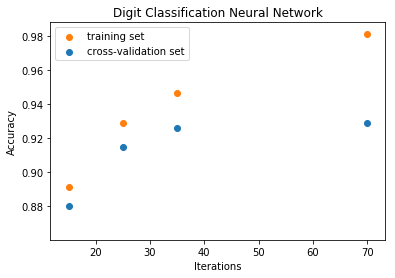

In [62]:
# Plot accuracy of NN predictions as a function of iterations 
cv_plotnn = plt.scatter(iters_test, Acc_re[:,1], label = 'cv')
train_plotnn = plt.scatter(iters_test, Acc_re[:,0], label = 'train')
plt.legend([train_plotnn, cv_plotnn], ['training set', 'cross-validation set'])


plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Digit Classification Neural Network')